In [1]:
from skimage.io import imread, imshow
from skimage import feature

In [2]:
import numpy as np

In [3]:
from sklearn import ensemble

In [4]:
import glob

In [5]:
image_names = glob.glob("proboscis_data/*.png")

In [6]:
from xml.etree import ElementTree

In [7]:
et = ElementTree.parse("proboscis_data/annotations.xml")

In [8]:
images = et.findall("image")

In [9]:
labels = {}
for image in images:
    name = image.attrib['name']
    tip = image.find("points")
    if tip is not None:
        labels[name] = tip.attrib['points']

In [10]:
coords = {}
for key,val in labels.items():
    x_str, y_str = val.split(',')
    x = float(x_str)
    y = float(y_str)
    coords[key] = (x,y)

In [11]:
imgs = {}
for image in images:
    name = image.attrib['name']
    img = imread(name)
    imgs[name] = img

In [12]:
targets = {}
for key,val in coords.items():
    targets[key] = np.zeros((600,100), dtype=np.float32)
    x,y = val
    x_i = round(x)
    y_i = round(y)
    targets[key][y_i - 5: y_i + 5, x_i - 5 : x_i + 5] = 1

In [13]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers, losses, optimizers, Model
from tensorflow.keras.utils import  plot_model

2023-04-11 18:22:47.592732: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-11 18:22:47.697193: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-11 18:22:47.700463: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-11 18:22:47.700477: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [14]:
# from https://blog.paperspace.com/unet-architecture-image-segmentation/

def convolution_block(input_lay, filters=64):
    conv1 = layers.Conv2D(filters, kernel_size=(3,3), padding="same")(input_lay)
    bn1 = layers.BatchNormalization()(conv1)
    act1 = layers.ReLU()(bn1)
    
    conv2 = layers.Conv2D(filters, kernel_size=(3,3), padding="same")(act1)
    bn2 = layers.BatchNormalization()(conv2)
    act2 = layers.ReLU()(bn2)
    
    return act2

def encoder(input_lay, filters=64):
    enc1 = convolution_block(input_lay, filters)
    max_pool1 = layers.MaxPooling2D()(enc1)
    return enc1, max_pool1

def decoder(input_lay, skip_lay, filters=64):
    upsample = layers.Conv2DTranspose(filters, (2,2), strides=2, padding="same")(input_lay)
    connect_skip = layers.Concatenate()([upsample, skip_lay])
    out = convolution_block(connect_skip, filters)
    return out

def u_net(image_size):
    input1 = layers.Input(image_size)
    
    skip1, enc1 = encoder(input1, 64)
    skip2, enc2 = encoder(enc1, 64 * 2)
    skip3, enc3 = encoder(enc2, 64 * 4)
    skip4, enc4 = encoder(enc3, 64 * 8)
    
    conv_block = convolution_block(enc4, 64*16)
    
    dec1 = decoder(conv_block, skip4, 64 * 8)
    dec2 = decoder(dec1, skip3, 64 * 4)
    dec3 = decoder(dec2, skip2, 64 * 2)
    dec4 = decoder(dec3, skip1, 64)
    
    out = layers.Conv2D(filters=1, kernel_size=(1,1), padding="same", activation="sigmoid")(dec4)
    
    model = Model(input1, out)
    
    return model

2023-04-11 18:22:48.915141: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-11 18:22:48.915159: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-11 18:22:48.915173: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Silicon-Eye): /proc/driver/nvidia/version does not exist
2023-04-11 18:22:48.915351: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


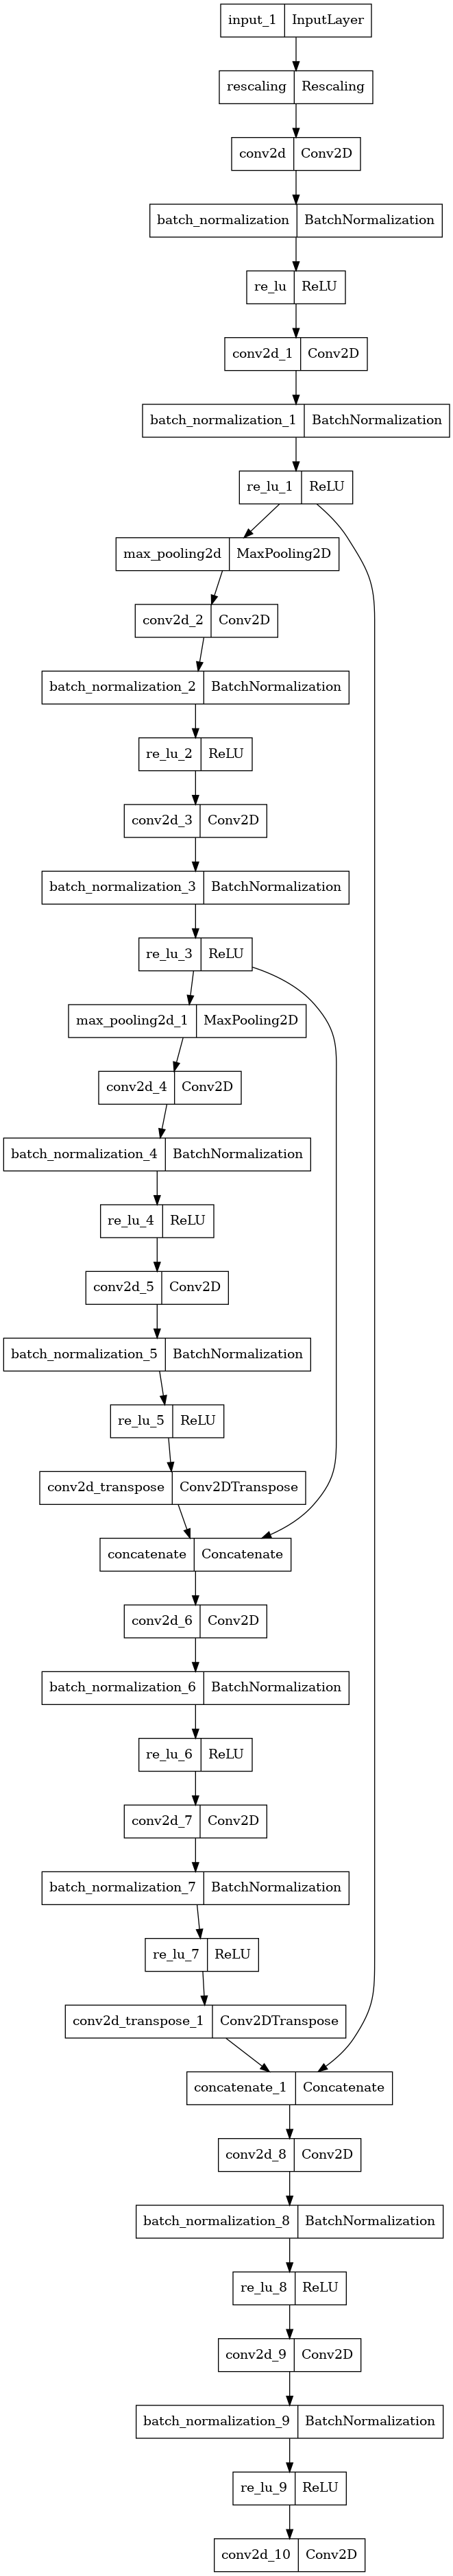

In [15]:
inp = layers.Input(shape=[600,100,1])
res = layers.Rescaling(1.0/255)(inp)
#x = layers.Conv2D(filters=4, kernel_size=(3,3))(res)

skip1, enc1 = encoder(res, 64)
skip2, enc2 = encoder(enc1, 64 * 2)
#skip3, enc3 = encoder(enc2, 64 * 4)

conv_block = convolution_block(enc2, 64 * 4)

dec1 = decoder(conv_block, skip2, 64 * 2)
dec2 = decoder(dec1, skip1, 64)
#dec3 = decoder(dec2, skip1, 64)

f = layers.Flatten()(dec2)

#out = layers.Dense(1)(f)
out = layers.Conv2D(filters=1, kernel_size=(1,1))(dec2)

model = Model(inp, out)
model.compile(loss=losses.BinaryCrossentropy(), optimizer=optimizers.Adam())
plot_model(model)

/home/tomas/.local/lib/python3.10/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


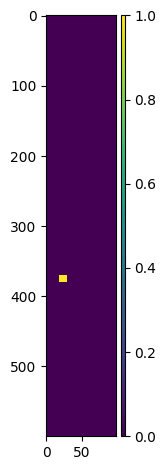

In [16]:
imshow(targets['proboscis_data/img0_2.png'])

In [20]:
inputs = []
outputs = []
for name in targets:
    outputs.append(targets[name])
    inputs.append(imgs[name])

inps = np.array(inputs)
outs = np.array(outputs)

In [21]:
inps.shape

(531, 600, 100)

In [22]:
outs.shape

(531, 600, 100)

In [23]:
inps = inps[...,np.newaxis]
outs = outs[...,np.newaxis]

In [24]:
inps.shape

(531, 600, 100, 1)

In [25]:
outs.shape

(531, 600, 100, 1)

In [26]:
model.fit(inps,outs)

17/17 [==============================] - 283s 16s/step - loss: 0.2683


In [28]:
q = model(inps[0:1])

In [29]:
b = q.numpy()

In [30]:
b.shape

(1, 600, 100, 1)

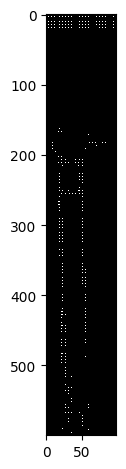

In [34]:
imshow(b[0,:,:,0] > 0)

/home/tomas/.local/lib/python3.10/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


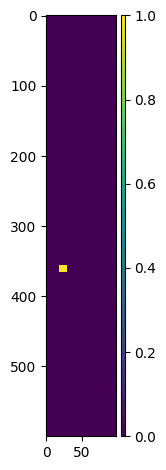

In [35]:
imshow(outs[0,:,:,0])

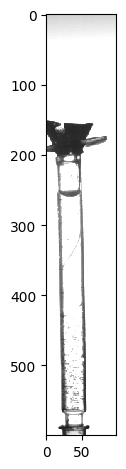

In [36]:
imshow(inps[0,:,:,0])